In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
lc = pd.read_csv('loan_data_2007_2014.csv')
lc.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
lc.shape

(466285, 75)

In [4]:
# check if there any duplicated columns
lc.duplicated().sum()

0

In [5]:
# no need to remove duplicated columns

In [6]:
# check the missing values in our dataset
missing = lc.isnull().sum()/lc.shape[0]*100
missing = missing.sort_values(ascending=False)
missing[missing>0]

inq_last_12m                   100.000000
total_bal_il                   100.000000
dti_joint                      100.000000
verification_status_joint      100.000000
annual_inc_joint               100.000000
open_acc_6m                    100.000000
open_il_6m                     100.000000
open_il_12m                    100.000000
open_il_24m                    100.000000
mths_since_rcnt_il             100.000000
il_util                        100.000000
open_rv_24m                    100.000000
total_cu_tl                    100.000000
inq_fi                         100.000000
max_bal_bc                     100.000000
all_util                       100.000000
open_rv_12m                    100.000000
mths_since_last_record          86.566585
mths_since_last_major_derog     78.773926
desc                            72.981975
mths_since_last_delinq          53.690554
next_pymnt_d                    48.728567
tot_cur_bal                     15.071469
tot_coll_amt                    15

In [7]:
# remove columns whose missing values more than 40%
lc.dropna(thresh=lc.shape[0]*0.6, axis=1, inplace=True)
lc.shape

(466285, 53)

In [8]:
# divide into categorical and numerical column for more data exploration
lc_cat = lc.select_dtypes(include=['object']).columns
lc_num = lc.select_dtypes(include=['float64','int64']).columns

In [9]:
# explore categorical columns
lc[lc_cat].describe().T

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
loan_status,466285,9,Current,224226
pymnt_plan,466285,2,n,466276


In [10]:
# remove columns whose too many unique values
lc.drop(['emp_title','url','title','zip_code'], axis=1, inplace=True)

# remove columns whose only 1 unique value
lc.drop('application_type', axis=1, inplace=True)

# remove columns whose particular value that is dominant
lc.drop('pymnt_plan', axis=1, inplace=True)

# remove columns which are considered useless as predictor
lc.drop(['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'], axis=1, inplace=True)

lc.shape

(466285, 43)

In [11]:
# explore numerical columns
lc[lc_num].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,466285.0,2.331420e+05,1.346050e+05,0.00,1.165710e+05,2.331420e+05,3.497130e+05,4.662840e+05
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01


In [12]:
# remove identity columns
lc.drop(['Unnamed: 0','id','member_id'], axis=1, inplace=True)
lc.shape

(466285, 40)

In [13]:
# define target label
lc['loan_status'].value_counts(normalize=True)

loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: proportion, dtype: float64

In [14]:
# assume charged off, Late (31-120 days), Late (16-30 days), Default, and-
# Does not meet the credit policy. Status:Charged Off as BAD BORROWERS
lc['loan_status'] = np.where(lc.loc[:,'loan_status'].isin
                               (['Charged Off','Default','Late (31-120 days)','Late (16-30 days)',
                                'Does not meet the credit policy. Status:Charged Off'
                                ]),1,0)

lc['loan_status'].value_counts(normalize=True)

loan_status
0    0.888081
1    0.111919
Name: proportion, dtype: float64

In [15]:
# okay, target label has been defined!

In [16]:
lc['loan_status'].head()

0    0
1    1
2    0
3    0
4    0
Name: loan_status, dtype: int32

In [17]:
# split data into training and testing set
X = lc.drop('loan_status', axis=1)
y = lc['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [18]:
X_train.shape, X_test.shape

((373028, 39), (93257, 39))

In [19]:
y_train.value_counts(normalize=True)

loan_status
0    0.888081
1    0.111919
Name: proportion, dtype: float64

In [20]:
y_test.value_counts(normalize=True)

loan_status
0    0.888083
1    0.111917
Name: proportion, dtype: float64

In [21]:
# conduct some data cleaning
cat = X_train.select_dtypes(include=['object']).columns
num = X_train.select_dtypes(include=['float64','int64']).columns

In [22]:
for col in cat:
    print(col, ' -----------> ', X_train[col].nunique())
    print(X_train[col].unique())
    print()

term  ----------->  2
[' 36 months' ' 60 months']

grade  ----------->  7
['C' 'D' 'B' 'A' 'F' 'E' 'G']

sub_grade  ----------->  35
['C1' 'C4' 'D4' 'B3' 'B2' 'D2' 'D3' 'D1' 'C2' 'C3' 'A1' 'A5' 'C5' 'B1'
 'B4' 'D5' 'F3' 'A4' 'B5' 'E2' 'A3' 'A2' 'E4' 'E1' 'E5' 'E3' 'F2' 'F5'
 'G1' 'G5' 'F1' 'G2' 'F4' 'G3' 'G4']

emp_length  ----------->  11
['9 years' '2 years' '10+ years' '8 years' '7 years' '< 1 year' '1 year'
 '3 years' '6 years' '4 years' '5 years' nan]

home_ownership  ----------->  6
['OWN' 'MORTGAGE' 'RENT' 'OTHER' 'NONE' 'ANY']

verification_status  ----------->  3
['Verified' 'Not Verified' 'Source Verified']

purpose  ----------->  14
['debt_consolidation' 'other' 'house' 'credit_card' 'medical'
 'major_purchase' 'car' 'home_improvement' 'vacation' 'small_business'
 'wedding' 'moving' 'educational' 'renewable_energy']

addr_state  ----------->  50
['FL' 'KY' 'NY' 'NJ' 'OH' 'AZ' 'IL' 'CA' 'WA' 'MN' 'SC' 'WI' 'OR' 'MD'
 'TN' 'PA' 'GA' 'TX' 'VA' 'AL' 'CO' 'MA' 'WY' 'OK' 'CT' 'NV'

In [23]:
# clean column which consist number and change it's data type
X_train['term'] = pd.to_numeric(X_train['term'].str.replace(' months', ''))

X_train['emp_length'] = X_train['emp_length'].str.replace(' years', '')
X_train['emp_length'] = X_train['emp_length'].str.replace(' year', '')
X_train['emp_length'] = X_train['emp_length'].str.replace('+', '')
X_train['emp_length'] = X_train['emp_length'].str.replace('< 1', '0')
X_train['emp_length'].fillna(value=0, inplace=True)
X_train['emp_length'] = pd.to_numeric(X_train['emp_length'])

In [24]:
X_train[['term', 'emp_length']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 373028 entries, 120814 to 397161
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   term        373028 non-null  int64
 1   emp_length  373028 non-null  int64
dtypes: int64(2)
memory usage: 8.5 MB


In [25]:
X_train[cat].isnull().sum()

term                   0
grade                  0
sub_grade              0
emp_length             0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
initial_list_status    0
dtype: int64

In [26]:
# conduct the same data cleaning for testing set too

In [27]:
# clean column which consist number and change it's data type
X_test['term'] = pd.to_numeric(X_test['term'].str.replace(' months', ''))

X_test['emp_length'] = X_test['emp_length'].str.replace(' years', '')
X_test['emp_length'] = X_test['emp_length'].str.replace(' year', '')
X_test['emp_length'] = X_test['emp_length'].str.replace('+', '')
X_test['emp_length'] = X_test['emp_length'].str.replace('< 1', '0')
X_test['emp_length'].fillna(value=0, inplace=True)
X_test['emp_length'] = pd.to_numeric(X_test['emp_length'])

In [28]:
X_test[['term', 'emp_length']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 93257 entries, 124850 to 175867
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   term        93257 non-null  int64
 1   emp_length  93257 non-null  int64
dtypes: int64(2)
memory usage: 2.1 MB


In [29]:
X_test[cat].isnull().sum()

term                   0
grade                  0
sub_grade              0
emp_length             0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
initial_list_status    0
dtype: int64

In [30]:
# handle missing values in numerical column
num_miss = X_train[num].isnull().sum()[X_train[num].isnull().sum()>0]
num_miss

annual_inc                        3
delinq_2yrs                      25
inq_last_6mths                   25
open_acc                         25
pub_rec                          25
revol_util                      269
total_acc                        25
collections_12_mths_ex_med      117
acc_now_delinq                   25
tot_coll_amt                  56210
tot_cur_bal                   56210
total_rev_hi_lim              56210
dtype: int64

In [31]:
X_train[num_miss.index] = X_train[num_miss.index].fillna(X_train[num_miss.index].median())

In [32]:
num_miss = X_train[num].isnull().sum()[X_train[num].isnull().sum()>0]
num_miss

Series([], dtype: int64)

In [33]:
num_miss = X_test[num].isnull().sum()[X_test[num].isnull().sum()>0]
num_miss

annual_inc                        1
delinq_2yrs                       4
inq_last_6mths                    4
open_acc                          4
pub_rec                           4
revol_util                       71
total_acc                         4
collections_12_mths_ex_med       28
acc_now_delinq                    4
tot_coll_amt                  14066
tot_cur_bal                   14066
total_rev_hi_lim              14066
dtype: int64

In [34]:
X_test[num_miss.index] = X_test[num_miss.index].fillna(X_test[num_miss.index].median())

In [35]:
num_miss = X_test[num].isnull().sum()[X_test[num].isnull().sum()>0]
num_miss

Series([], dtype: int64)

In [36]:
cat = X_train.select_dtypes(include=['object']).columns
num = X_train.select_dtypes(include=['float64','int64']).columns

In [37]:
# feature encoding
encoder = LabelEncoder()
for col in cat:
    encoder.fit(X_train[col].unique())
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [38]:
# feature scaling
scaler = StandardScaler()
for col in num:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

In [39]:
# decision tree classifier model
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree_preds = dtree.predict(X_test)
print('model : DecisionTreeClassifier')
print('accuracy score : %', round(accuracy_score(y_test,dtree_preds)*100,2)) 
print('f1 score : %', round(f1_score(y_test,dtree_preds,average='micro')*100,2))
print('precision score : %', round(precision_score(y_test,dtree_preds,average='micro')*100,2))
print('recall score : %', round(recall_score(y_test,dtree_preds,average='micro')*100,2))
print()

model : DecisionTreeClassifier
accuracy score : % 95.39
f1 score : % 95.39
precision score : % 95.39
recall score : % 95.39



<Axes: ylabel='feature'>

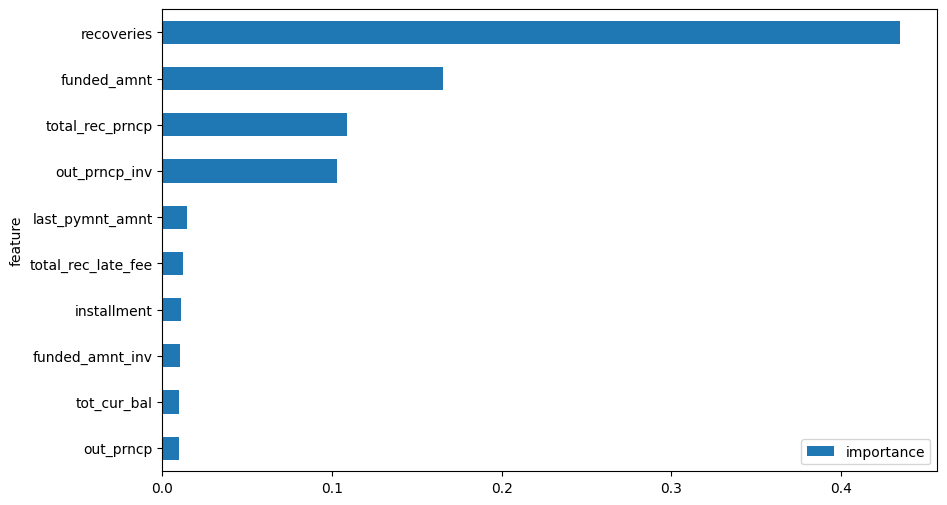

In [40]:
# feature importance of decision tree classifier model
dtree_fi = pd.DataFrame({'feature' : X.columns, 'importance' : dtree.feature_importances_})
dtree_fi = dtree_fi.sort_values('importance', ascending=True)
dtree_fi = dtree_fi.tail(10)
dtree_fi.plot(x='feature', y='importance', kind='barh', figsize=(10, 6))

In [41]:
# logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)
print('model : LinerRegression')
print('accuracy score : %', round(accuracy_score(y_test,logreg_preds)*100,2)) 
print('f1 score : %', round(f1_score(y_test,logreg_preds,average='micro')*100,2))
print('precision score : %', round(precision_score(y_test,logreg_preds,average='micro')*100,2))
print('recall score : %', round(recall_score(y_test,logreg_preds,average='micro')*100,2))
print()

model : LinerRegression
accuracy score : % 97.88
f1 score : % 97.88
precision score : % 97.88
recall score : % 97.88



<Axes: ylabel='Feature'>

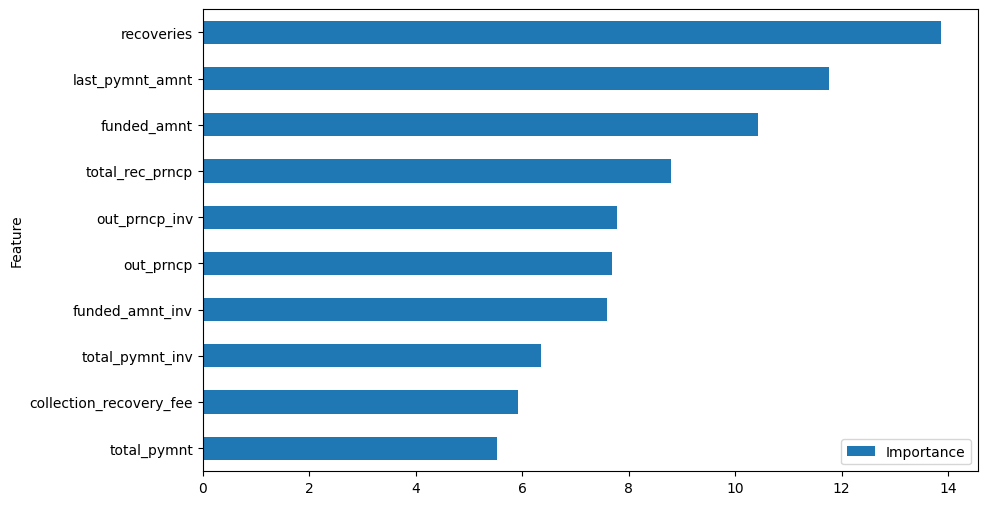

In [42]:
# feature importance of logistic regression model
logreg_fi = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(logreg.coef_[0])})
logreg_fi = logreg_fi.sort_values('Importance', ascending=True)
logreg_fi = logreg_fi.tail(10)
logreg_fi.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))